In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from scipy.spatial.distance import cdist

# Path to dataset
base_path = r"C:\Users\91974\Downloads\Working projects\IPlantSpec\G7"

# Feature extraction function (color histogram + texture using LBP)
def extract_features(image):
    # Resize image
    image = cv2.resize(image, (128, 128))
    
    # Compute color histogram
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()

    # Convert to grayscale for texture analysis
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Local Binary Pattern (LBP)
    lbp = cv2.calcHist([gray], [0], None, [256], [0, 256])
    lbp = cv2.normalize(lbp, lbp).flatten()

    # Combine features
    combined_features = np.hstack([hist, lbp])
    return combined_features

# Load data
data = []
labels = []

for species in os.listdir(base_path):
    species_path = os.path.join(base_path, species)
    if os.path.isdir(species_path):
        for img_file in os.listdir(species_path):
            img_path = os.path.join(species_path, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                features = extract_features(img)
                data.append(features)
                labels.append(species)

# Convert to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
data, labels = smote.fit_resample(data, labels)

# Scale features
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Split data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Train an ensemble model (Voting Classifier)
svm = SVC(kernel='rbf', probability=True, class_weight='balanced', C=10, gamma=0.1)
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
ensemble = VotingClassifier(estimators=[('svm', svm), ('rf', rf)], voting='soft')
ensemble.fit(X_train, y_train)

# Classification report
predictions = ensemble.predict(X_test)
print("Classification Report:\n", classification_report(y_test, predictions))

# Compute inter-class similarity
class_means = []
for class_id in np.unique(labels):
    class_features = data[labels == class_id]
    class_mean = np.mean(class_features, axis=0)
    class_means.append(class_mean)

class_means = np.array(class_means)
similarity_matrix = 1 - cdist(class_means, class_means, metric='cosine')

print("\nInter-Class Similarity Matrix:")
print(similarity_matrix)

# Save results
np.savetxt("inter_class_similarity.csv", similarity_matrix, delimiter=",", fmt="%.4f")


Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.78      0.80        23
           1       0.83      0.94      0.88        31
           2       0.94      0.87      0.91        39
           3       0.81      1.00      0.90        22
           4       0.96      0.77      0.86        31
           5       0.76      0.73      0.75        30
           6       0.88      0.92      0.90        25
           7       0.81      0.88      0.84        33
           8       0.89      0.96      0.93        26
           9       0.90      0.87      0.88        30
          10       0.97      0.91      0.94        32
          11       0.85      0.82      0.84        34

    accuracy                           0.87       356
   macro avg       0.87      0.87      0.87       356
weighted avg       0.87      0.87      0.87       356


Inter-Class Similarity Matrix:
[[ 1.          0.31749922 -0.08471467 -0.34944523 -0.10009604 -0.13237862
   

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.78      0.80        23
           1       0.83      0.97      0.90        31
           2       0.94      0.87      0.91        39
           3       0.81      1.00      0.90        22
           4       0.96      0.77      0.86        31
           5       0.76      0.73      0.75        30
           6       0.88      0.92      0.90        25
           7       0.81      0.88      0.84        33
           8       0.89      0.96      0.93        26
           9       0.93      0.87      0.90        30
          10       0.97      0.91      0.94        32
          11       0.85      0.82      0.84        34

    accuracy                           0.87       356
   macro avg       0.87      0.87      0.87       356
weighted avg       0.87      0.87      0.87       356

Confusion Matrix:
 [[18  0  0  0  0  0  0  3  2  0  0  0]
 [ 0 30  1  0  0  0  0  0  0  0  0  0]
 [ 0  0 34  

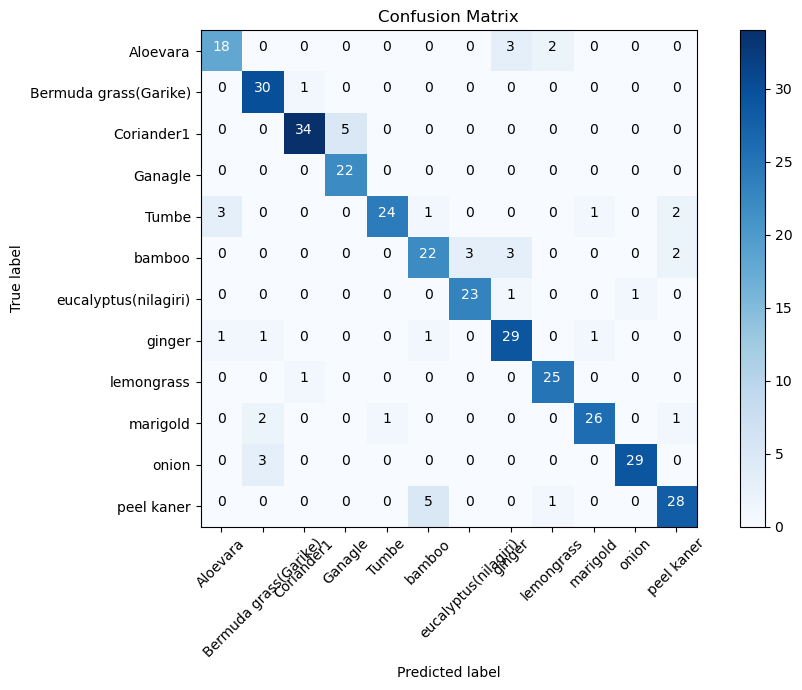

NameError: name 'test_labels' is not defined

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE
from scipy.spatial.distance import cdist

# Path to dataset
base_path = r"C:\Users\91974\Downloads\Working projects\IPlantSpec\G7"

# Feature extraction function (color histogram + texture using LBP)
def extract_features(image):
    # Resize image
    image = cv2.resize(image, (128, 128))
    
    # Compute color histogram
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()

    # Convert to grayscale for texture analysis
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Local Binary Pattern (LBP)
    lbp = cv2.calcHist([gray], [0], None, [256], [0, 256])
    lbp = cv2.normalize(lbp, lbp).flatten()

    # Combine features
    combined_features = np.hstack([hist, lbp])
    return combined_features

# Load data
data = []
labels = []

for species in os.listdir(base_path):
    species_path = os.path.join(base_path, species)
    if os.path.isdir(species_path):
        for img_file in os.listdir(species_path):
            img_path = os.path.join(species_path, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                features = extract_features(img)
                data.append(features)
                labels.append(species)

# Convert to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
labels_binarized = label_binarize(labels, classes=np.unique(labels))

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
data, labels = smote.fit_resample(data, labels)
labels_binarized = label_binarize(labels, classes=np.unique(labels))

# Scale features
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Split data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Train an ensemble model (Voting Classifier)
svm = SVC(kernel='rbf', probability=True, class_weight='balanced', C=10, gamma=0.1)
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
ensemble = VotingClassifier(estimators=[('svm', svm), ('rf', rf)], voting='soft')
ensemble.fit(X_train, y_train)

# Classification report
predictions = ensemble.predict(X_test)
pred_prob = ensemble.predict_proba(X_test)
print("Classification Report:\n", classification_report(y_test, predictions))

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
print("Confusion Matrix:\n", cm)

# Plot Confusion Matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, label_encoder.classes_)

from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# Assuming pred_prob (prediction probabilities) and test_labels (true labels for the test set)
# Ensure labels are binarized for multi-class metrics
labels_binarized = label_binarize(test_labels, classes=np.unique(test_labels))

# Ensure prediction probabilities match the number of test samples
if pred_prob.shape[0] != labels_binarized.shape[0]:
    raise ValueError(f"Mismatch: pred_prob has {pred_prob.shape[0]} samples, "
                     f"but labels_binarized has {labels_binarized.shape[0]} samples.")

# Precision-Recall Curve and AUC
precision = dict()
recall = dict()
pr_auc = dict()
for i in range(labels_binarized.shape[1]):
    precision[i], recall[i], _ = precision_recall_curve(labels_binarized[:, i], pred_prob[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

# Plot Precision-Recall Curve
plt.figure()
for i in range(labels_binarized.shape[1]):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AUC = {pr_auc[i]:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.grid()
plt.show()

# ROC Curve and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(labels_binarized.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure()
for i in range(labels_binarized.shape[1]):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="best")
plt.grid()
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, pred_prob.argmax(axis=1))
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(np.arange(len(np.unique(test_labels))), np.unique(test_labels), rotation=45)
plt.yticks(np.arange(len(np.unique(test_labels))), np.unique(test_labels))
plt.tight_layout()
plt.show()

# Compute Inter-Class Similarity
class_means = []
for class_id in np.unique(test_labels):
    class_features = data[test_labels == class_id]
    class_mean = np.mean(class_features, axis=0)
    class_means.append(class_mean)

class_means = np.array(class_means)
similarity_matrix = 1 - cdist(class_means, class_means, metric='cosine')

print("\nInter-Class Similarity Matrix:")
print(similarity_matrix)

# Save Inter-Class Similarity Matrix to a CSV file
np.savetxt("inter_class_similarity.csv", similarity_matrix, delimiter=",", fmt="%.4f")



Classification Report:
                       precision    recall  f1-score   support

             Aloevara       0.66      0.76      0.70        41
Bermuda grass(Garike)       0.75      0.88      0.81        41
           Coriander1       0.60      0.83      0.69        41
              Ganagle       0.81      1.00      0.89        38
                Tumbe       0.48      0.48      0.48        44
               bamboo       0.51      0.48      0.49        42
 eucalyptus(nilagiri)       0.60      0.51      0.55        41
               ginger       0.71      0.56      0.63        39
           lemongrass       0.87      0.85      0.86        39
             marigold       0.71      0.72      0.72        40
                onion       0.91      0.72      0.81        43
           peel kaner       0.52      0.37      0.43        41

             accuracy                           0.68       490
            macro avg       0.68      0.68      0.67       490
         weighted avg       0.

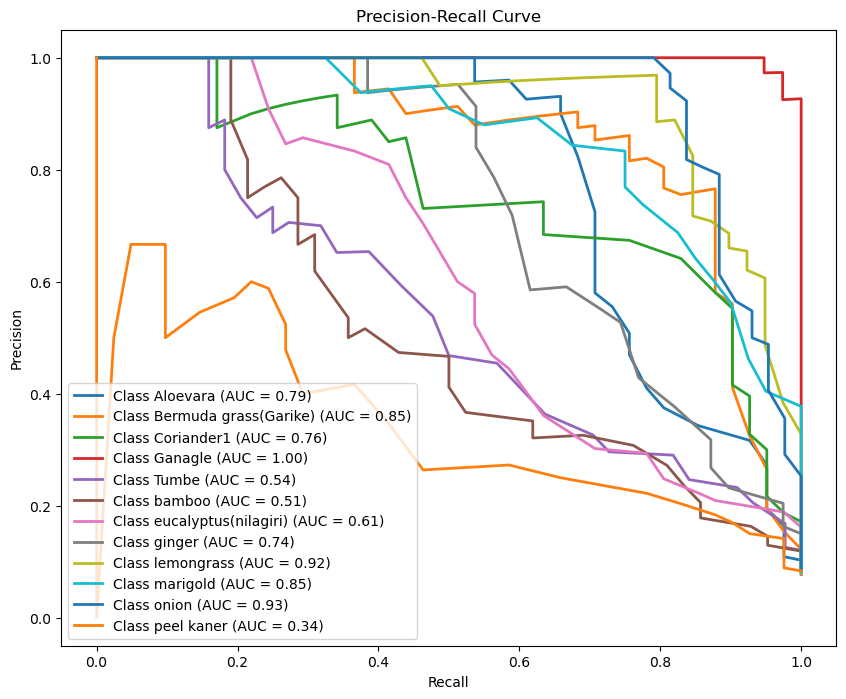

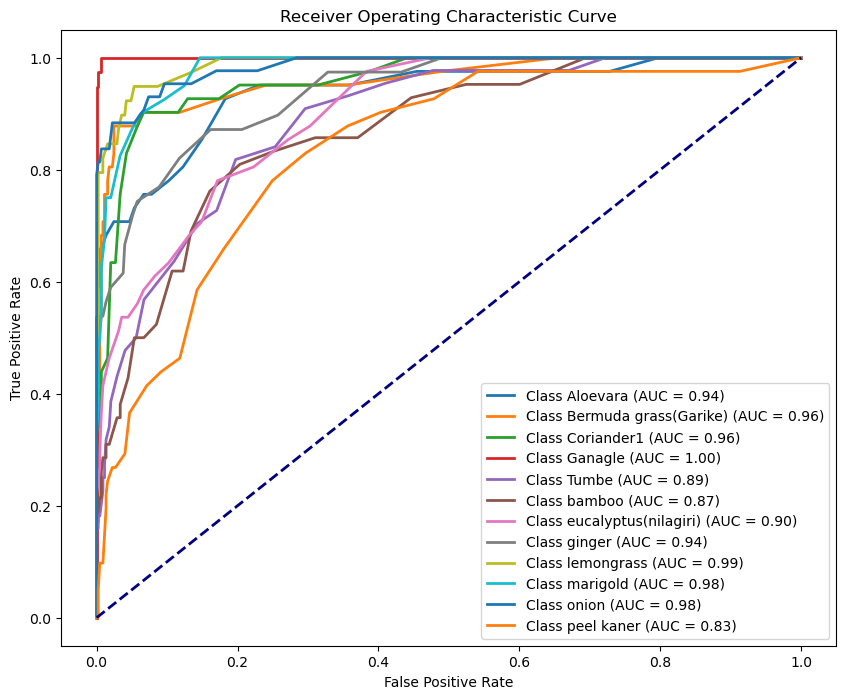


Inter-Class Similarity Matrix:
[[ 1.          0.12771119 -0.27996043 -0.51417648 -0.24665564  0.12431501
  -0.05888468  0.03931989  0.2024967  -0.31083013  0.16794434  0.01549632]
 [ 0.12771119  1.         -0.90422227 -0.69980409  0.04357426  0.1607694
   0.65059202 -0.13129048 -0.71661956 -0.10050715  0.81701267  0.7524229 ]
 [-0.27996043 -0.90422227  1.          0.78882159 -0.01671256 -0.30352191
  -0.70265982  0.15561394  0.58116249  0.13014153 -0.80639857 -0.73614402]
 [-0.51417648 -0.69980409  0.78882159  1.          0.15854674 -0.3439199
  -0.47587663  0.06557572  0.22570437  0.12273408 -0.72930349 -0.5203394 ]
 [-0.24665564  0.04357426 -0.01671256  0.15854674  1.          0.26283684
  -0.11731086  0.47756493 -0.52163967  0.5110433  -0.34518743  0.10946258]
 [ 0.12431501  0.1607694  -0.30352191 -0.3439199   0.26283684  1.
  -0.1016443   0.56455792 -0.38733553  0.60253287 -0.13732484  0.09599087]
 [-0.05888468  0.65059202 -0.70265982 -0.47587663 -0.11731086 -0.1016443
   1.      

In [12]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from PIL import Image  # For image resizing

# Define the path to the dataset
dataset_path = r"C:\Users\91974\Downloads\Working projects\IPlantSpec\G7"

# Load data and labels
data = []
labels = []
class_names = sorted(os.listdir(dataset_path))  # Assuming folder names are class names

# Define a fixed size for resizing images
fixed_size = (128, 128)

for idx, class_name in enumerate(class_names):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        for file in os.listdir(class_folder):
            file_path = os.path.join(class_folder, file)
            try:
                # Load and resize image
                image = Image.open(file_path).convert('RGB')  # Ensure 3 channels
                image = image.resize(fixed_size)
                image = np.array(image).flatten()  # Flatten the image to a 1D feature vector
                data.append(image)
                labels.append(idx)
            except Exception as e:
                print(f"Error loading {file_path}: {e}")

# Convert to NumPy arrays
data = np.array(data)
labels = np.array(labels)

# Shuffle and normalize the data
data, labels = shuffle(data, labels, random_state=42)
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42, stratify=labels)

# Apply PCA for dimensionality reduction (optional, for large feature spaces)
pca = PCA(n_components=100)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict probabilities for test data
pred_prob = model.predict_proba(X_test)
y_pred = model.predict(X_test)

# Evaluate the classifier
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Binarize the labels for multi-class metrics
labels_binarized = label_binarize(y_test, classes=np.unique(labels))

# Precision-Recall Curve and AUC
precision = dict()
recall = dict()
pr_auc = dict()
for i in range(labels_binarized.shape[1]):
    precision[i], recall[i], _ = precision_recall_curve(labels_binarized[:, i], pred_prob[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 8))
for i in range(labels_binarized.shape[1]):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {class_names[i]} (AUC = {pr_auc[i]:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.show()

# ROC Curve and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(labels_binarized.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(10, 8))
for i in range(labels_binarized.shape[1]):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="best")
plt.show()

# Compute inter-class similarity
class_means = []
for class_id in range(len(class_names)):
    class_features = data[labels == class_id]
    class_mean = np.mean(class_features, axis=0)
    class_means.append(class_mean)

class_means = np.array(class_means)
similarity_matrix = 1 - cdist(class_means, class_means, metric="cosine")

print("\nInter-Class Similarity Matrix:")
print(similarity_matrix)

# Save results
np.savetxt("inter_class_similarity.csv", similarity_matrix, delimiter=",", fmt="%.4f")


In [14]:
import os
import pandas as pd

# Create a directory to save the outputs
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

# Save the classification report
classification_report_dict = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
classification_report_df = pd.DataFrame(classification_report_dict).transpose()
classification_report_path = os.path.join(output_dir, "classification_report.csv")
classification_report_df.to_csv(classification_report_path, index=True)
print(f"Classification report saved to: {classification_report_path}")

# Save the confusion matrix
confusion_matrix_path = os.path.join(output_dir, "confusion_matrix.csv")
np.savetxt(confusion_matrix_path, confusion_matrix(y_test, y_pred), delimiter=",", fmt="%d")
print(f"Confusion matrix saved to: {confusion_matrix_path}")

# Save Precision-Recall Curve data
pr_curve_path = os.path.join(output_dir, "precision_recall_curves.csv")
with open(pr_curve_path, "w") as pr_file:
    pr_file.write("Class,Recall,Precision\n")
    for i in range(labels_binarized.shape[1]):
        for r, p in zip(recall[i], precision[i]):
            pr_file.write(f"{class_names[i]},{r},{p}\n")
print(f"Precision-Recall Curve data saved to: {pr_curve_path}")

# Save the ROC Curve data
roc_curve_path = os.path.join(output_dir, "roc_curves.csv")
with open(roc_curve_path, "w") as roc_file:
    roc_file.write("Class,False Positive Rate,True Positive Rate\n")
    for i in range(labels_binarized.shape[1]):
        for f, t in zip(fpr[i], tpr[i]):
            roc_file.write(f"{class_names[i]},{f},{t}\n")
print(f"ROC Curve data saved to: {roc_curve_path}")

# Save Precision-Recall Curve plot
pr_plot_path = os.path.join(output_dir, "precision_recall_curve.png")
plt.figure(figsize=(10, 8))
for i in range(labels_binarized.shape[1]):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {class_names[i]} (AUC = {pr_auc[i]:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.savefig(pr_plot_path)
print(f"Precision-Recall Curve plot saved to: {pr_plot_path}")
plt.close()

# Save ROC Curve plot
roc_plot_path = os.path.join(output_dir, "roc_curve.png")
plt.figure(figsize=(10, 8))
for i in range(labels_binarized.shape[1]):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="best")
plt.savefig(roc_plot_path)
print(f"ROC Curve plot saved to: {roc_plot_path}")
plt.close()

# Save Inter-Class Similarity Matrix
similarity_matrix_path = os.path.join(output_dir, "inter_class_similarity.csv")
np.savetxt(similarity_matrix_path, similarity_matrix, delimiter=",", fmt="%.4f")
print(f"Inter-class similarity matrix saved to: {similarity_matrix_path}")


Classification report saved to: outputs\classification_report.csv
Confusion matrix saved to: outputs\confusion_matrix.csv
Precision-Recall Curve data saved to: outputs\precision_recall_curves.csv
ROC Curve data saved to: outputs\roc_curves.csv
Precision-Recall Curve plot saved to: outputs\precision_recall_curve.png
ROC Curve plot saved to: outputs\roc_curve.png
Inter-class similarity matrix saved to: outputs\inter_class_similarity.csv


In [14]:
import os
import pandas as pd

# Create a directory to save the outputs
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

# Save the classification report
classification_report_dict = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
classification_report_df = pd.DataFrame(classification_report_dict).transpose()
classification_report_path = os.path.join(output_dir, "classification_report.csv")
classification_report_df.to_csv(classification_report_path, index=True)
print(f"Classification report saved to: {classification_report_path}")

# Save the confusion matrix
confusion_matrix_path = os.path.join(output_dir, "confusion_matrix.csv")
np.savetxt(confusion_matrix_path, confusion_matrix(y_test, y_pred), delimiter=",", fmt="%d")
print(f"Confusion matrix saved to: {confusion_matrix_path}")

# Save Precision-Recall Curve data
pr_curve_path = os.path.join(output_dir, "precision_recall_curves.csv")
with open(pr_curve_path, "w") as pr_file:
    pr_file.write("Class,Recall,Precision\n")
    for i in range(labels_binarized.shape[1]):
        for r, p in zip(recall[i], precision[i]):
            pr_file.write(f"{class_names[i]},{r},{p}\n")
print(f"Precision-Recall Curve data saved to: {pr_curve_path}")

# Save the ROC Curve data
roc_curve_path = os.path.join(output_dir, "roc_curves.csv")
with open(roc_curve_path, "w") as roc_file:
    roc_file.write("Class,False Positive Rate,True Positive Rate\n")
    for i in range(labels_binarized.shape[1]):
        for f, t in zip(fpr[i], tpr[i]):
            roc_file.write(f"{class_names[i]},{f},{t}\n")
print(f"ROC Curve data saved to: {roc_curve_path}")

# Save Precision-Recall Curve plot
pr_plot_path = os.path.join(output_dir, "precision_recall_curve.png")
plt.figure(figsize=(10, 8))
for i in range(labels_binarized.shape[1]):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {class_names[i]} (AUC = {pr_auc[i]:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.savefig(pr_plot_path)
print(f"Precision-Recall Curve plot saved to: {pr_plot_path}")
plt.close()

# Save ROC Curve plot
roc_plot_path = os.path.join(output_dir, "roc_curve.png")
plt.figure(figsize=(10, 8))
for i in range(labels_binarized.shape[1]):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="best")
plt.savefig(roc_plot_path)
print(f"ROC Curve plot saved to: {roc_plot_path}")
plt.close()

# Save Inter-Class Similarity Matrix
similarity_matrix_path = os.path.join(output_dir, "inter_class_similarity.csv")
np.savetxt(similarity_matrix_path, similarity_matrix, delimiter=",", fmt="%.4f")
print(f"Inter-class similarity matrix saved to: {similarity_matrix_path}")


Classification report saved to: outputs\classification_report.csv
Confusion matrix saved to: outputs\confusion_matrix.csv
Precision-Recall Curve data saved to: outputs\precision_recall_curves.csv
ROC Curve data saved to: outputs\roc_curves.csv
Precision-Recall Curve plot saved to: outputs\precision_recall_curve.png
ROC Curve plot saved to: outputs\roc_curve.png
Inter-class similarity matrix saved to: outputs\inter_class_similarity.csv


Similarity matrix saved to: outputs\similarity_matrix.csv
Similarity matrix heatmap saved to: outputs\similarity_matrix_heatmap.png


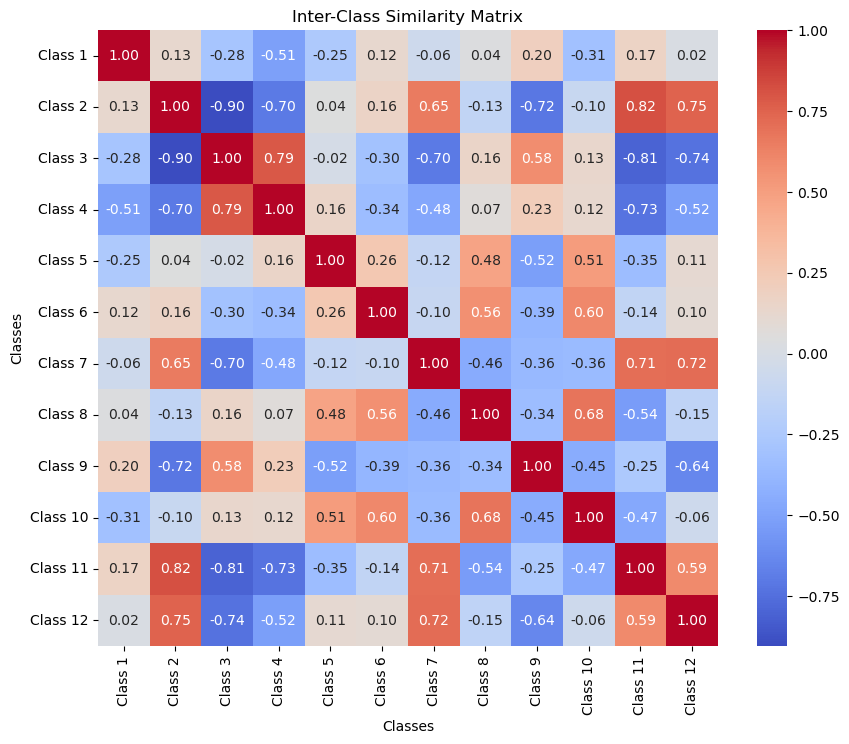

Distance matrix saved to: outputs\distance_matrix.csv
Distance matrix heatmap saved to: outputs\distance_matrix_heatmap.png


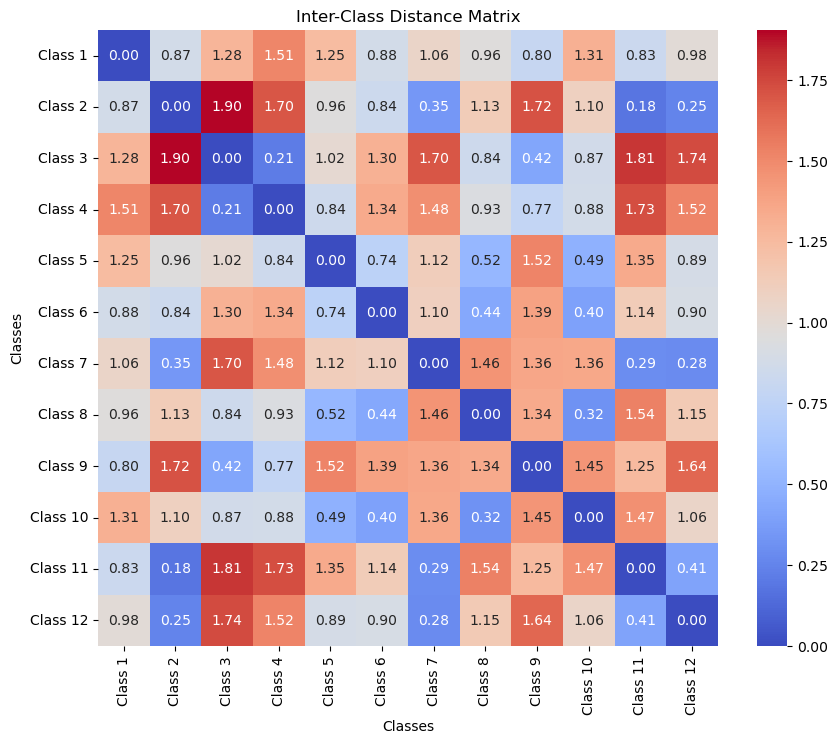

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Ensure output directory exists
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

# Given similarity matrix
similarity_matrix = np.array([
    [1.0, 0.12771119, -0.27996043, -0.51417648, -0.24665564, 0.12431501, -0.05888468, 0.03931989, 0.2024967, -0.31083013, 0.16794434, 0.01549632],
    [0.12771119, 1.0, -0.90422227, -0.69980409, 0.04357426, 0.1607694, 0.65059202, -0.13129048, -0.71661956, -0.10050715, 0.81701267, 0.7524229],
    [-0.27996043, -0.90422227, 1.0, 0.78882159, -0.01671256, -0.30352191, -0.70265982, 0.15561394, 0.58116249, 0.13014153, -0.80639857, -0.73614402],
    [-0.51417648, -0.69980409, 0.78882159, 1.0, 0.15854674, -0.3439199, -0.47587663, 0.06557572, 0.22570437, 0.12273408, -0.72930349, -0.5203394],
    [-0.24665564, 0.04357426, -0.01671256, 0.15854674, 1.0, 0.26283684, -0.11731086, 0.47756493, -0.52163967, 0.5110433, -0.34518743, 0.10946258],
    [0.12431501, 0.1607694, -0.30352191, -0.3439199, 0.26283684, 1.0, -0.1016443, 0.56455792, -0.38733553, 0.60253287, -0.13732484, 0.09599087],
    [-0.05888468, 0.65059202, -0.70265982, -0.47587663, -0.11731086, -0.1016443, 1.0, -0.45673785, -0.3630996, -0.35815403, 0.70687029, 0.71513503],
    [0.03931989, -0.13129048, 0.15561394, 0.06557572, 0.47756493, 0.56455792, -0.45673785, 1.0, -0.34451968, 0.68433731, -0.53899858, -0.14766279],
    [0.2024967, -0.71661956, 0.58116249, 0.22570437, -0.52163967, -0.38733553, -0.3630996, -0.34451968, 1.0, -0.4478347, -0.25288222, -0.637044],
    [-0.31083013, -0.10050715, 0.13014153, 0.12273408, 0.5110433, 0.60253287, -0.35815403, 0.68433731, -0.4478347, 1.0, -0.47155939, -0.05800912],
    [0.16794434, 0.81701267, -0.80639857, -0.72930349, -0.34518743, -0.13732484, 0.70687029, -0.53899858, -0.25288222, -0.47155939, 1.0, 0.59166285],
    [0.01549632, 0.7524229, -0.73614402, -0.5203394, 0.10946258, 0.09599087, 0.71513503, -0.14766279, -0.637044, -0.05800912, 0.59166285, 1.0]
])

# Define class names (example)
class_names = [f"Class {i+1}" for i in range(similarity_matrix.shape[0])]

# Save the similarity matrix
similarity_matrix_path = os.path.join(output_dir, "similarity_matrix.csv")
np.savetxt(similarity_matrix_path, similarity_matrix, delimiter=",", fmt="%.4f")
print(f"Similarity matrix saved to: {similarity_matrix_path}")

# Plot and save the similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap="coolwarm",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Inter-Class Similarity Matrix")
plt.xlabel("Classes")
plt.ylabel("Classes")
similarity_matrix_plot_path = os.path.join(output_dir, "similarity_matrix_heatmap.png")
plt.savefig(similarity_matrix_plot_path)
print(f"Similarity matrix heatmap saved to: {similarity_matrix_plot_path}")
plt.show()

# Convert similarity matrix to distance matrix
distance_matrix = 1 - similarity_matrix  # Assuming similarity ranges from 0 to 1

# Save the distance matrix
distance_matrix_path = os.path.join(output_dir, "distance_matrix.csv")
np.savetxt(distance_matrix_path, distance_matrix, delimiter=",", fmt="%.4f")
print(f"Distance matrix saved to: {distance_matrix_path}")

# Plot and save the distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, annot=True, fmt=".2f", cmap="coolwarm",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Inter-Class Distance Matrix")
plt.xlabel("Classes")
plt.ylabel("Classes")
distance_matrix_plot_path = os.path.join(output_dir, "distance_matrix_heatmap.png")
plt.savefig(distance_matrix_plot_path)
print(f"Distance matrix heatmap saved to: {distance_matrix_plot_path}")
plt.show()
